In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import numpy as np
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['axes.linewidth'] = 3
plt.rc("font", family="Bookman Old Style", weight="bold")
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.
    This function creates a RadarAxes projection
     and registers it.
    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the
            # first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line 
            is closed by default"""
            return super().fill(closed=closed,
                                *args,
                                **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line 
            is closed by default"""
            lines = super().plot(*args,
                                 **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(
                np.degrees(theta),
                labels,
                size=10,
                fontfamily="Bookman Old Style")

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5)
            # and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5),
                                      num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError(
                    "Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be
                # 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(
                    axes=self,
                    spine_type='circle',
                    path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of
                # radius 1 centered at
                # (0, 0) but we want a polygon
                # of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(
                    Affine2D().scale(.5).translate(.5, .5)
                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError(
                    "Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [3]:
def max_min_normalize(X=None, y=None, feature="DG"):
    labels = y.unique()
    X_filtered = X.filter(regex="_" + feature, axis=1)
    typical_samples = [
        X_filtered[y == label].mean() for label in labels]
    typical_df = pd.concat(typical_samples,
                           axis=1, keys=labels).T
    numerator = typical_df.sub(
        typical_df.min(axis=1), axis=0)
    denominator = typical_df.max(axis=1) - typical_df.min(axis=1)
    return numerator.div(denominator, axis=0)

In [5]:
data = pd.read_csv("enose_dataset\\data.csv", header=0, index_col=0)
X_MOS = data.iloc[:, 0:56]
X_CSA = data.iloc[:, 56:80]
y = data["VOC"]

In [6]:
def radar_plot(X=None, y=None, feature=None):
    fingerprints = max_min_normalize(X, y, feature)
    N = len(fingerprints.columns)
    theta = radar_factory(N, frame='polygon')
    fig, axs = plt.subplots(
        figsize=(10, 6), nrows=2,
        ncols=3,
        subplot_kw=dict(projection='radar'),
        dpi=300)
    colors = ['b', 'r', 'g', 'm', 'y', 'c']
    spoke_labels = [col[:-1 * (len(feature)+1)]
                    for col in fingerprints.columns]
    titles = fingerprints.index
    for ax, title, label, color in zip(
            axs.flat, titles,
            spoke_labels, colors):
        ax.set_rgrids(
            [0.2, 0.4, 0.6, 0.8],
            size=6,
            fontfamily="Bookman Old Style")
        ax.set_title(
            title, weight='bold', size=18,
            position=(0.5, 1), pad=55,
            horizontalalignment='center',
            verticalalignment='top', color=color)
        ax.plot(theta, fingerprints.loc[title], color=color)
        ax.fill(theta, fingerprints.loc[title],
                facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        ax.xaxis.set_tick_params(pad=11)
    fig.tight_layout()

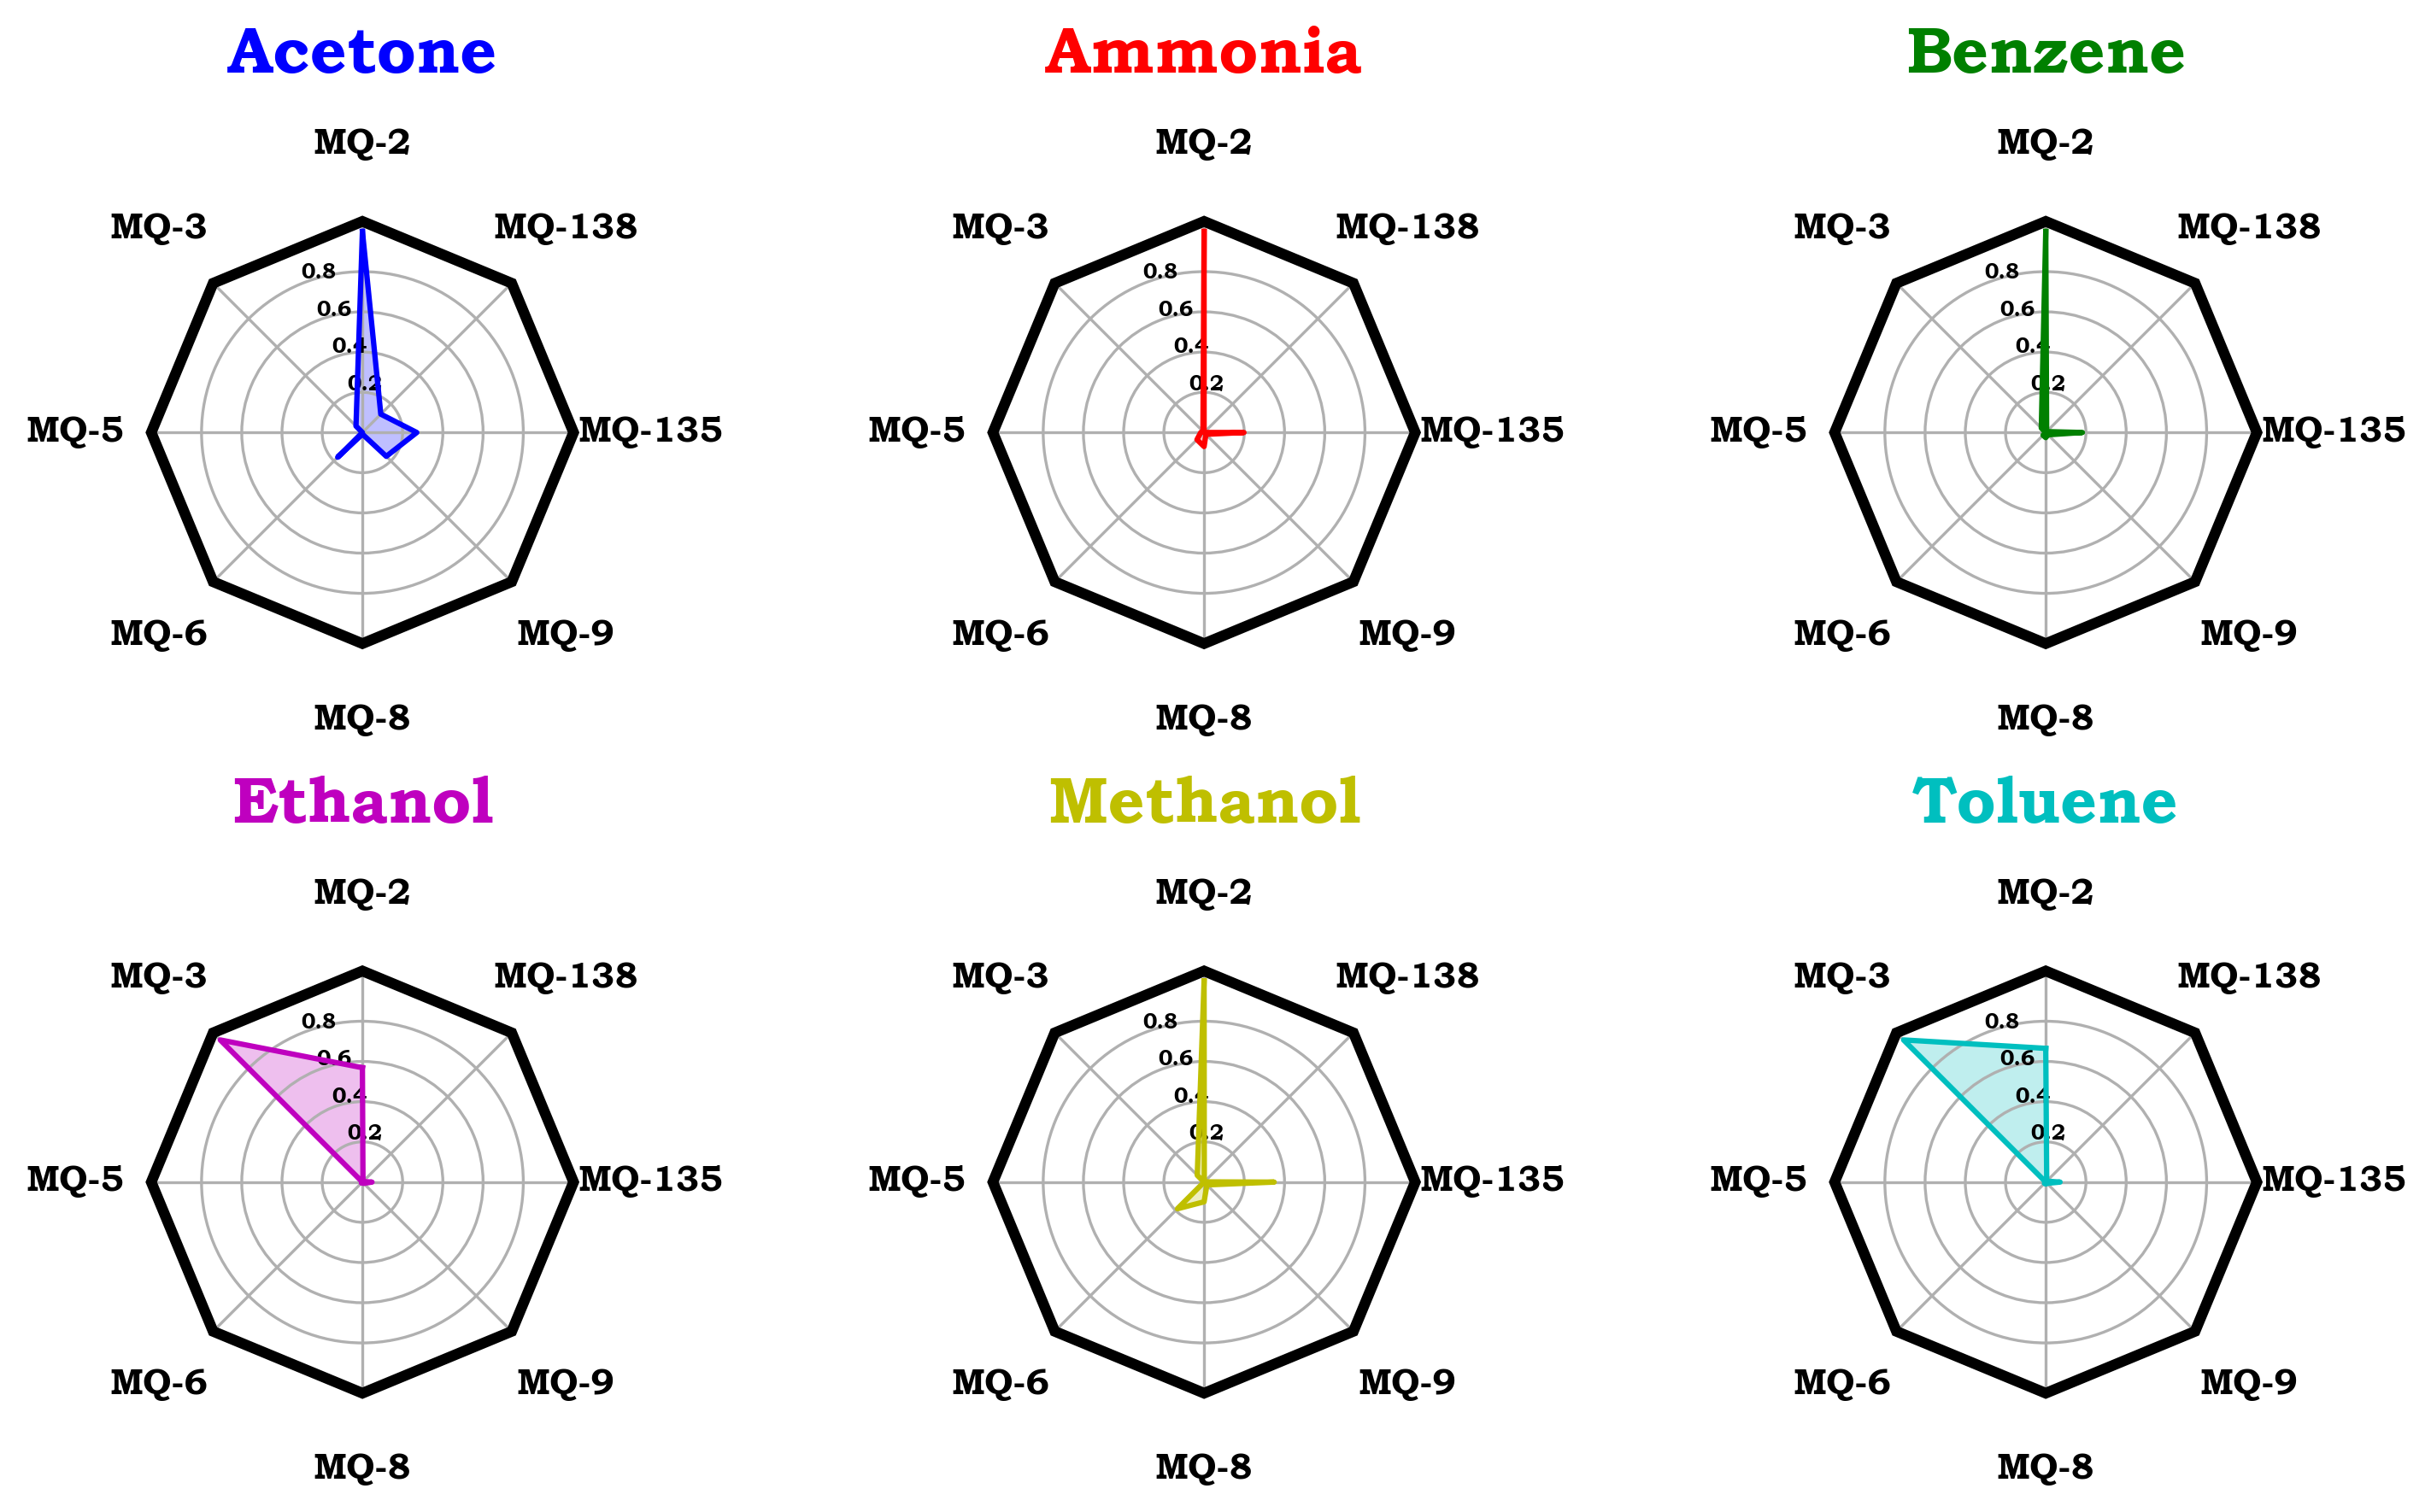

In [7]:
radar_plot(X_MOS, y, feature="AI")

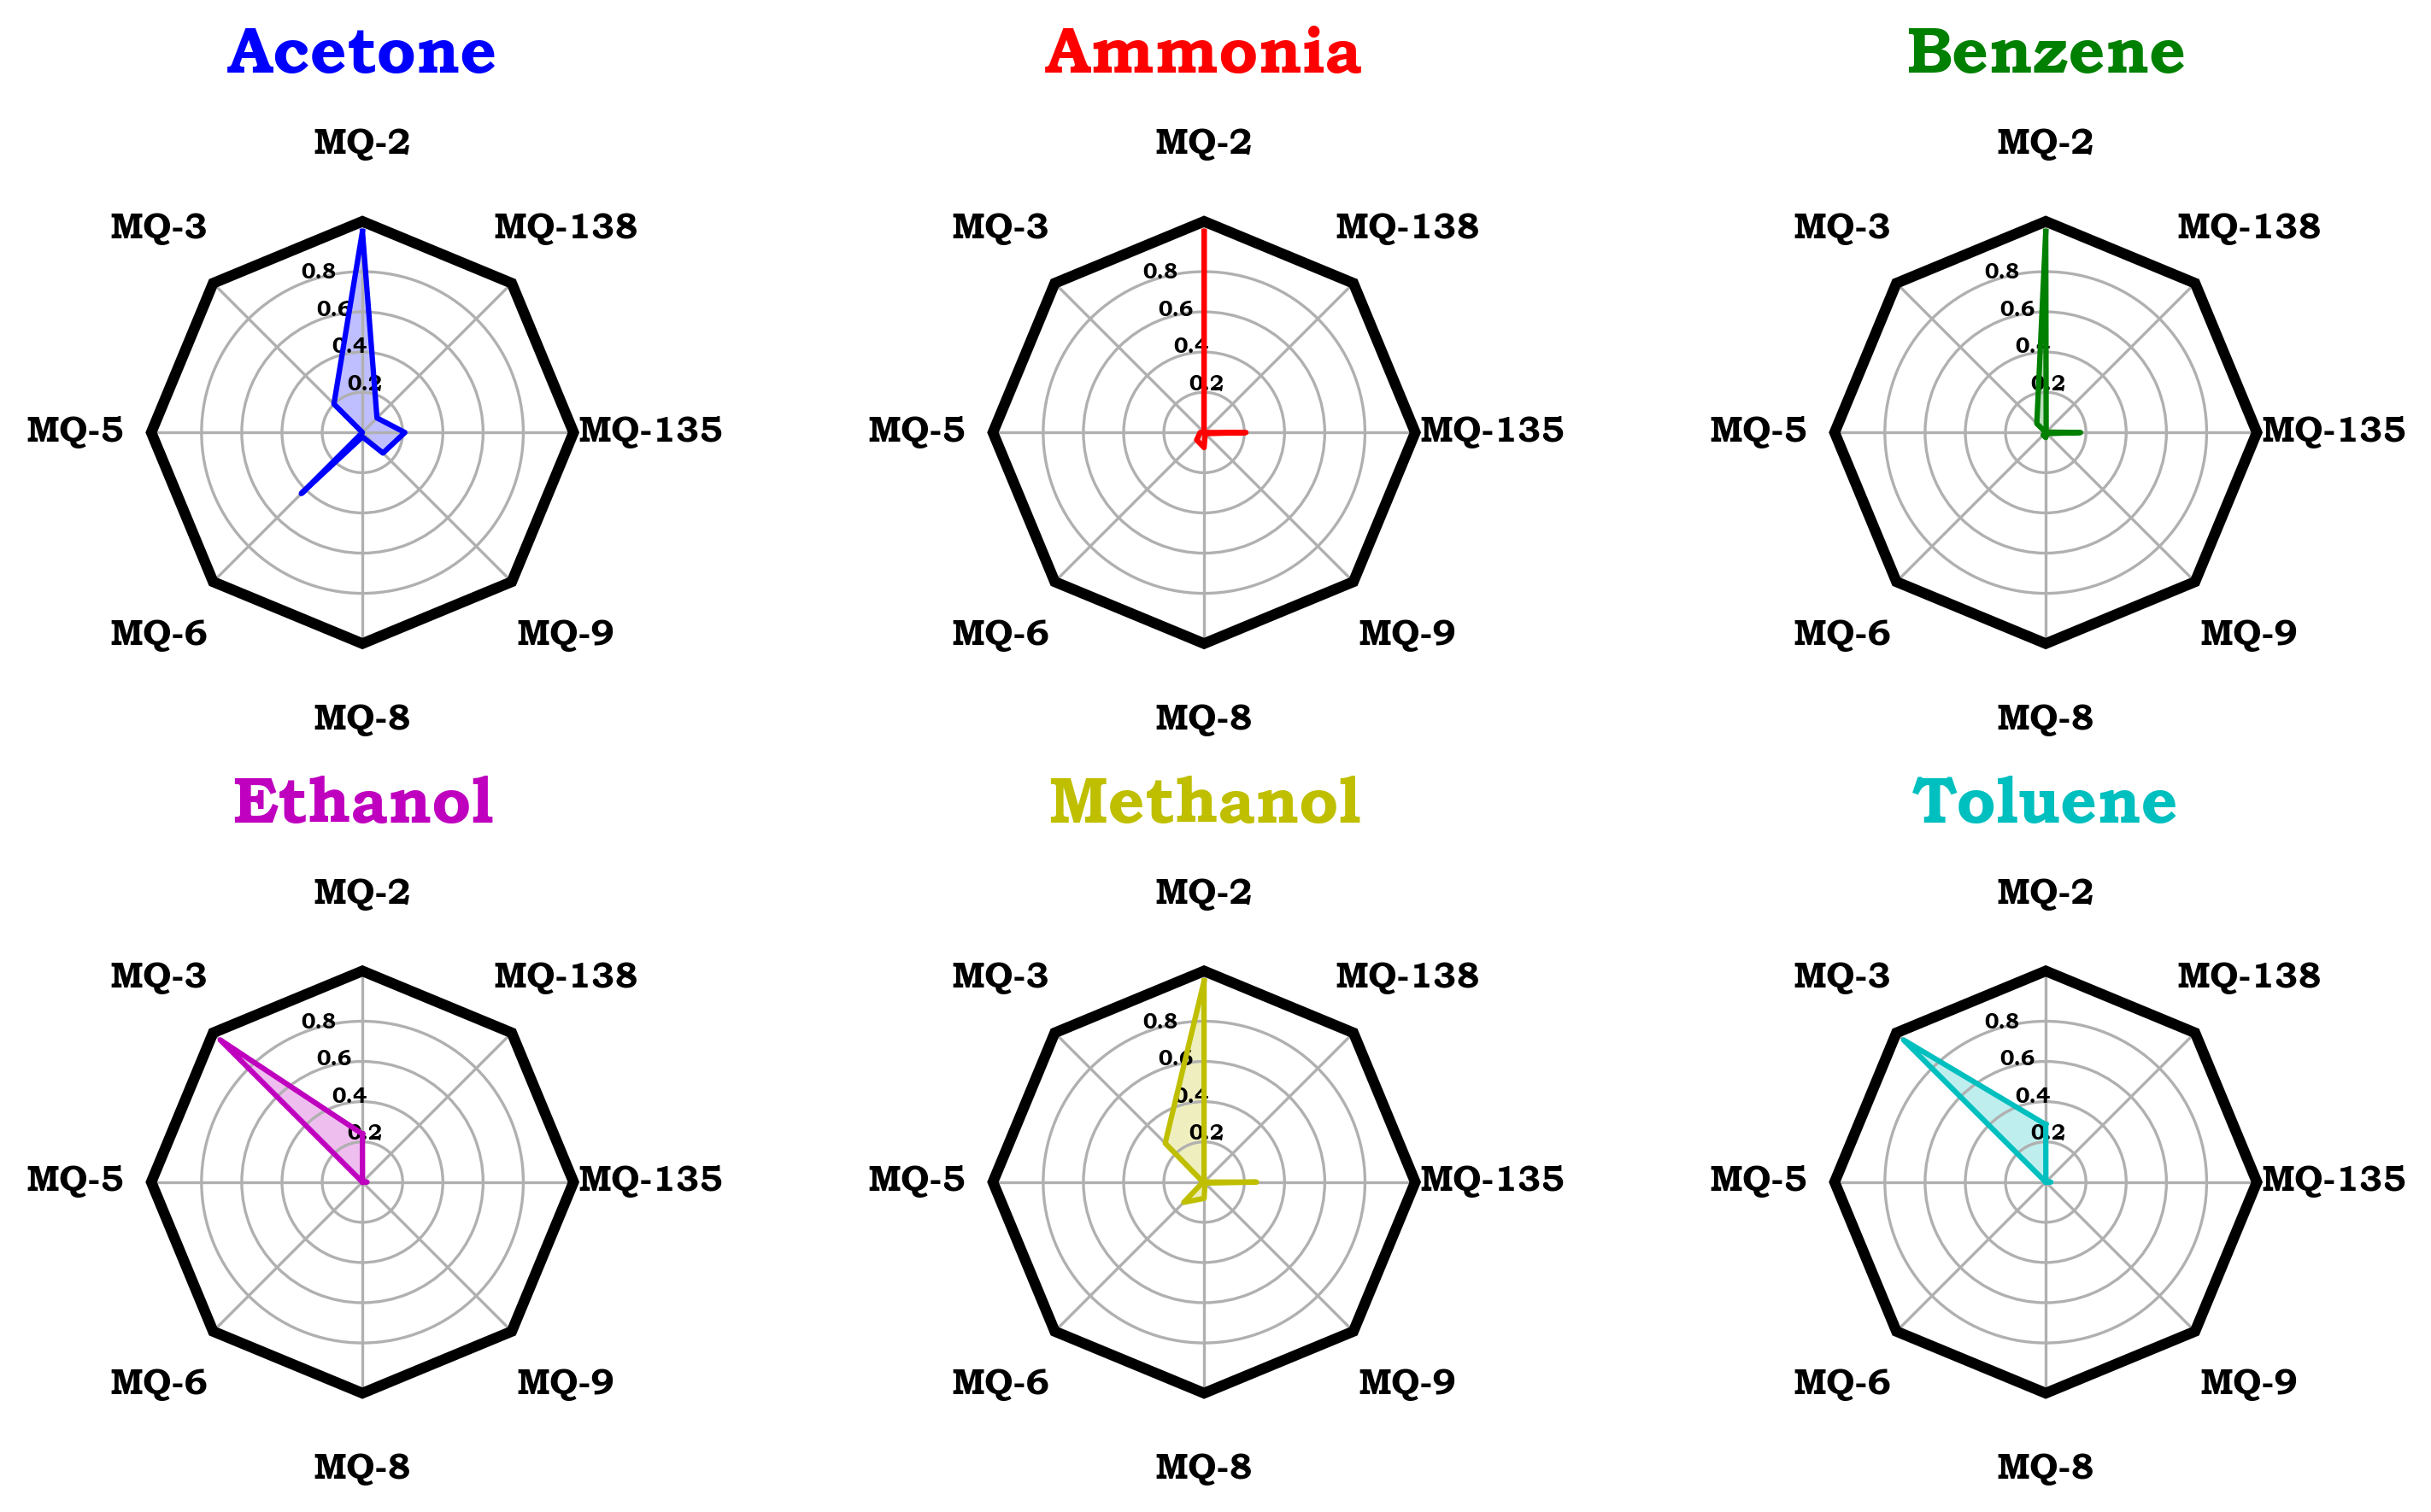

In [8]:
radar_plot(X_MOS, y, feature="DI")

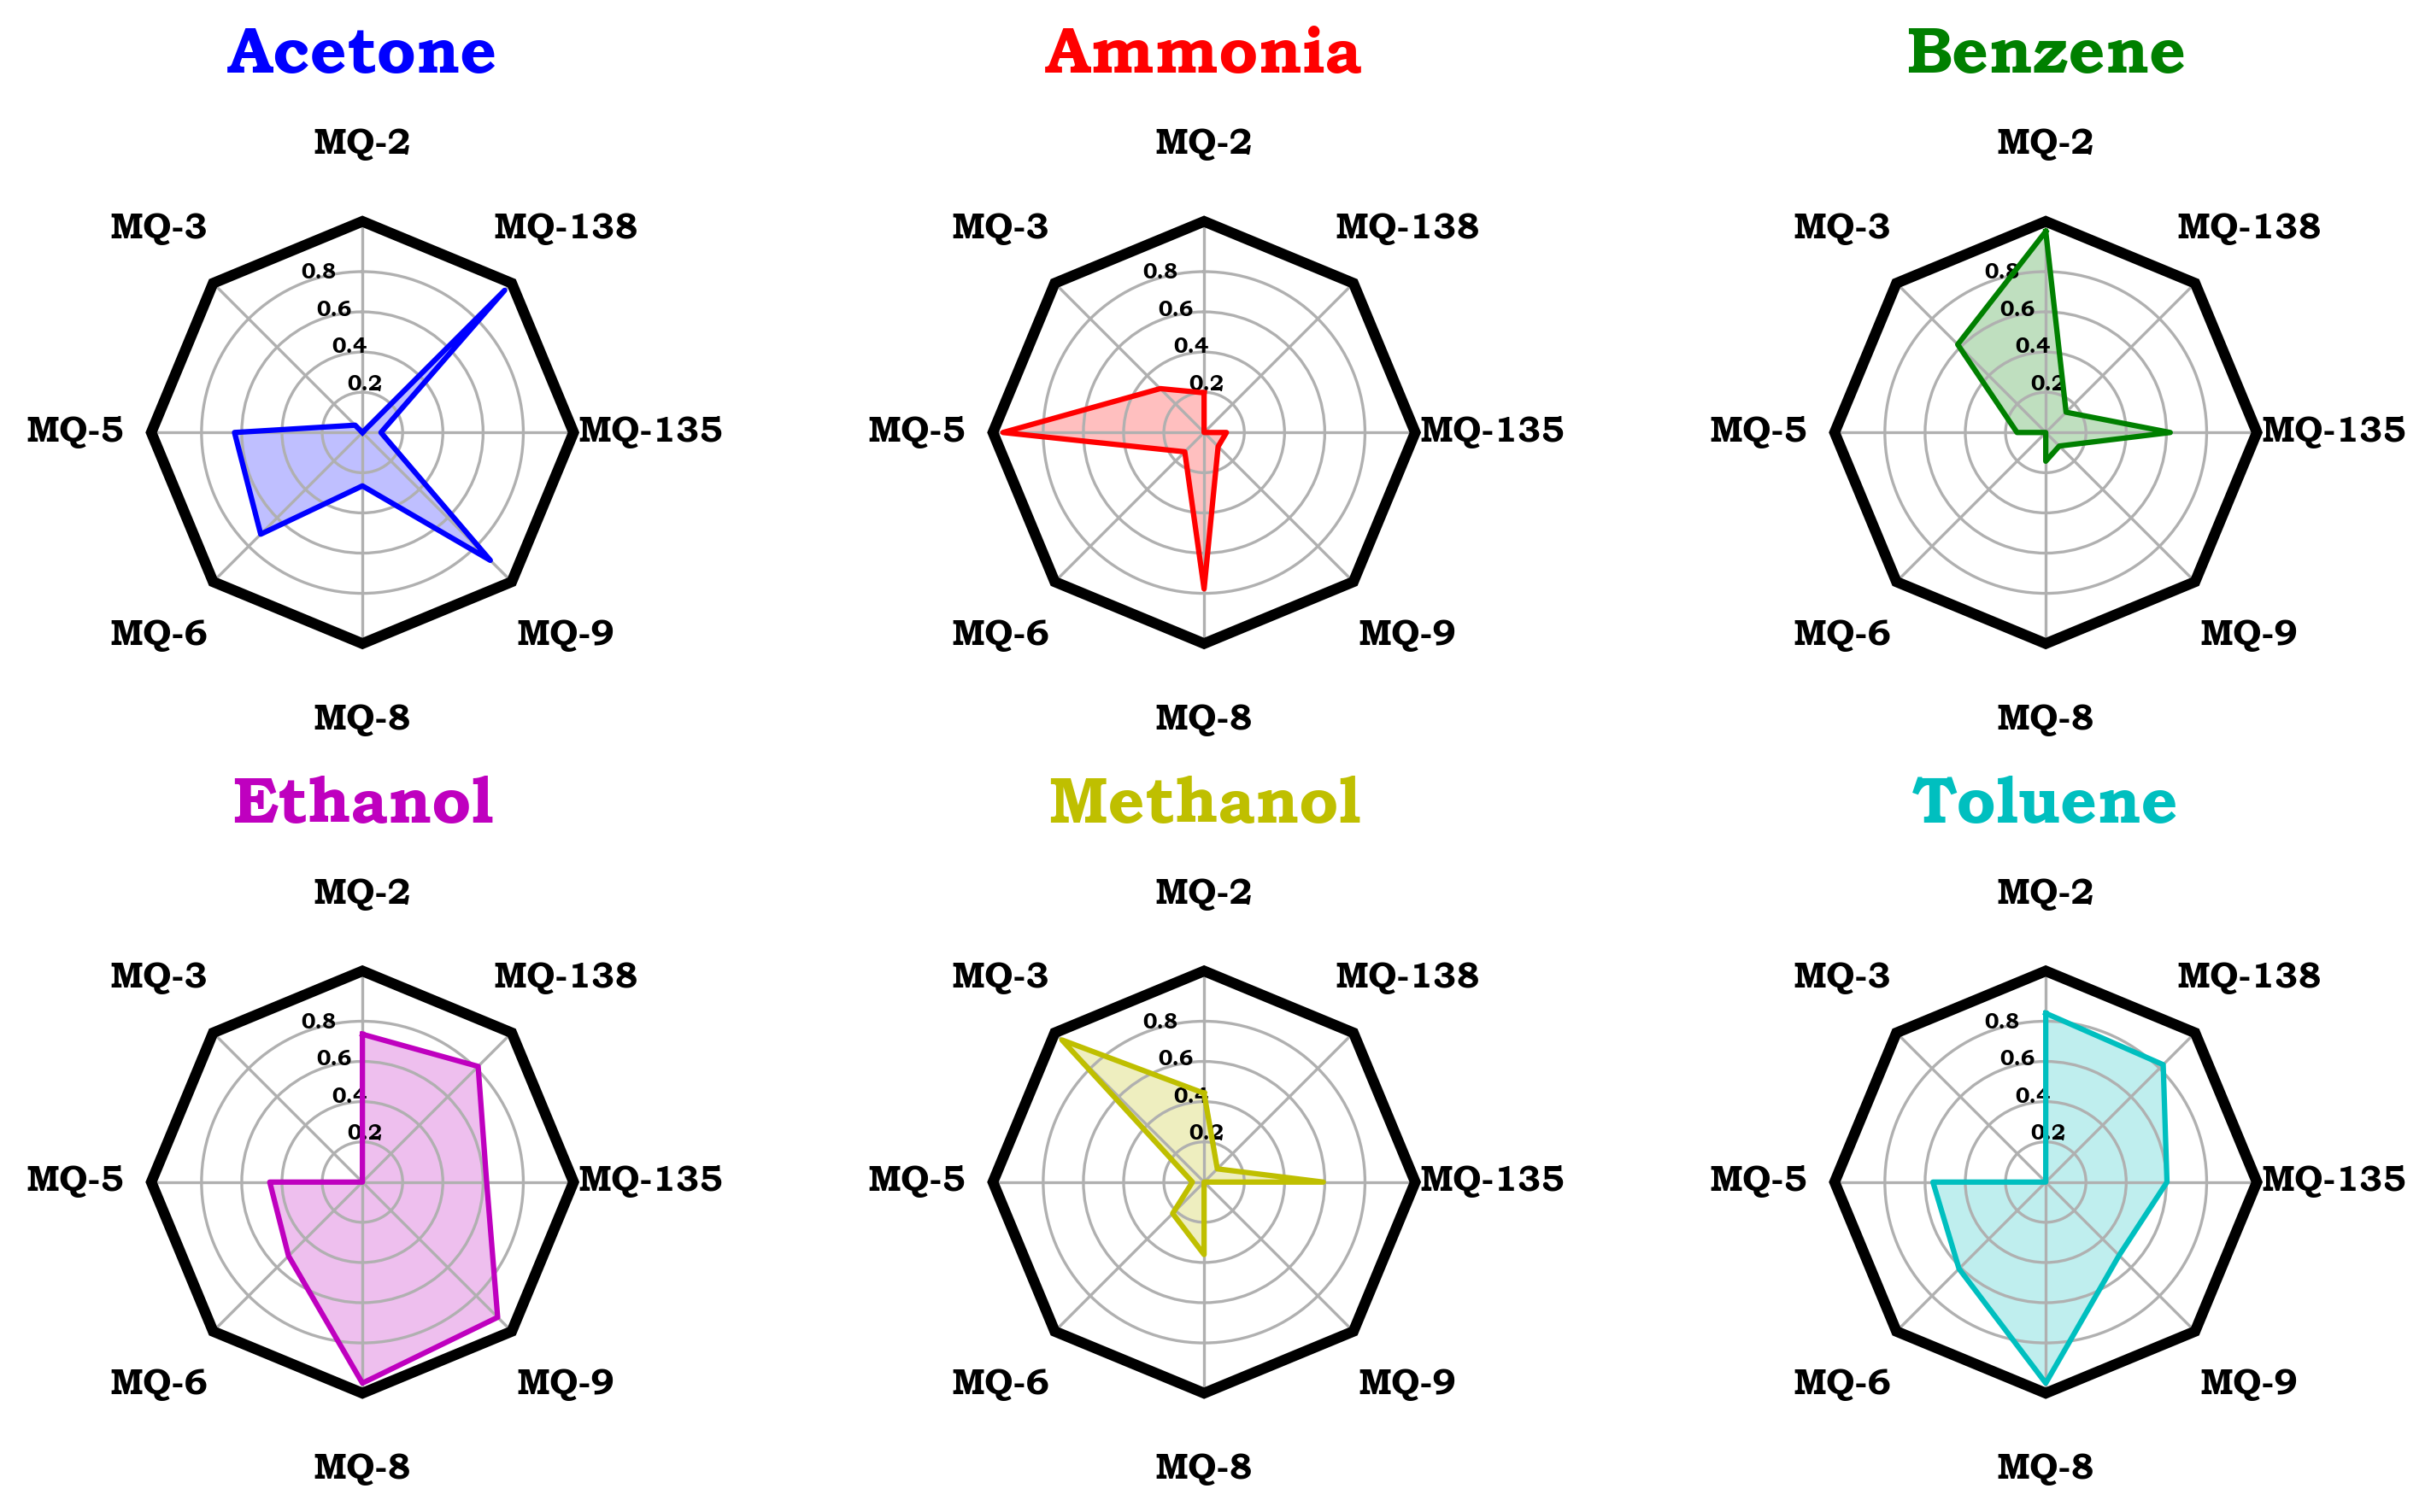

In [9]:
radar_plot(X_MOS, y, feature="RT")

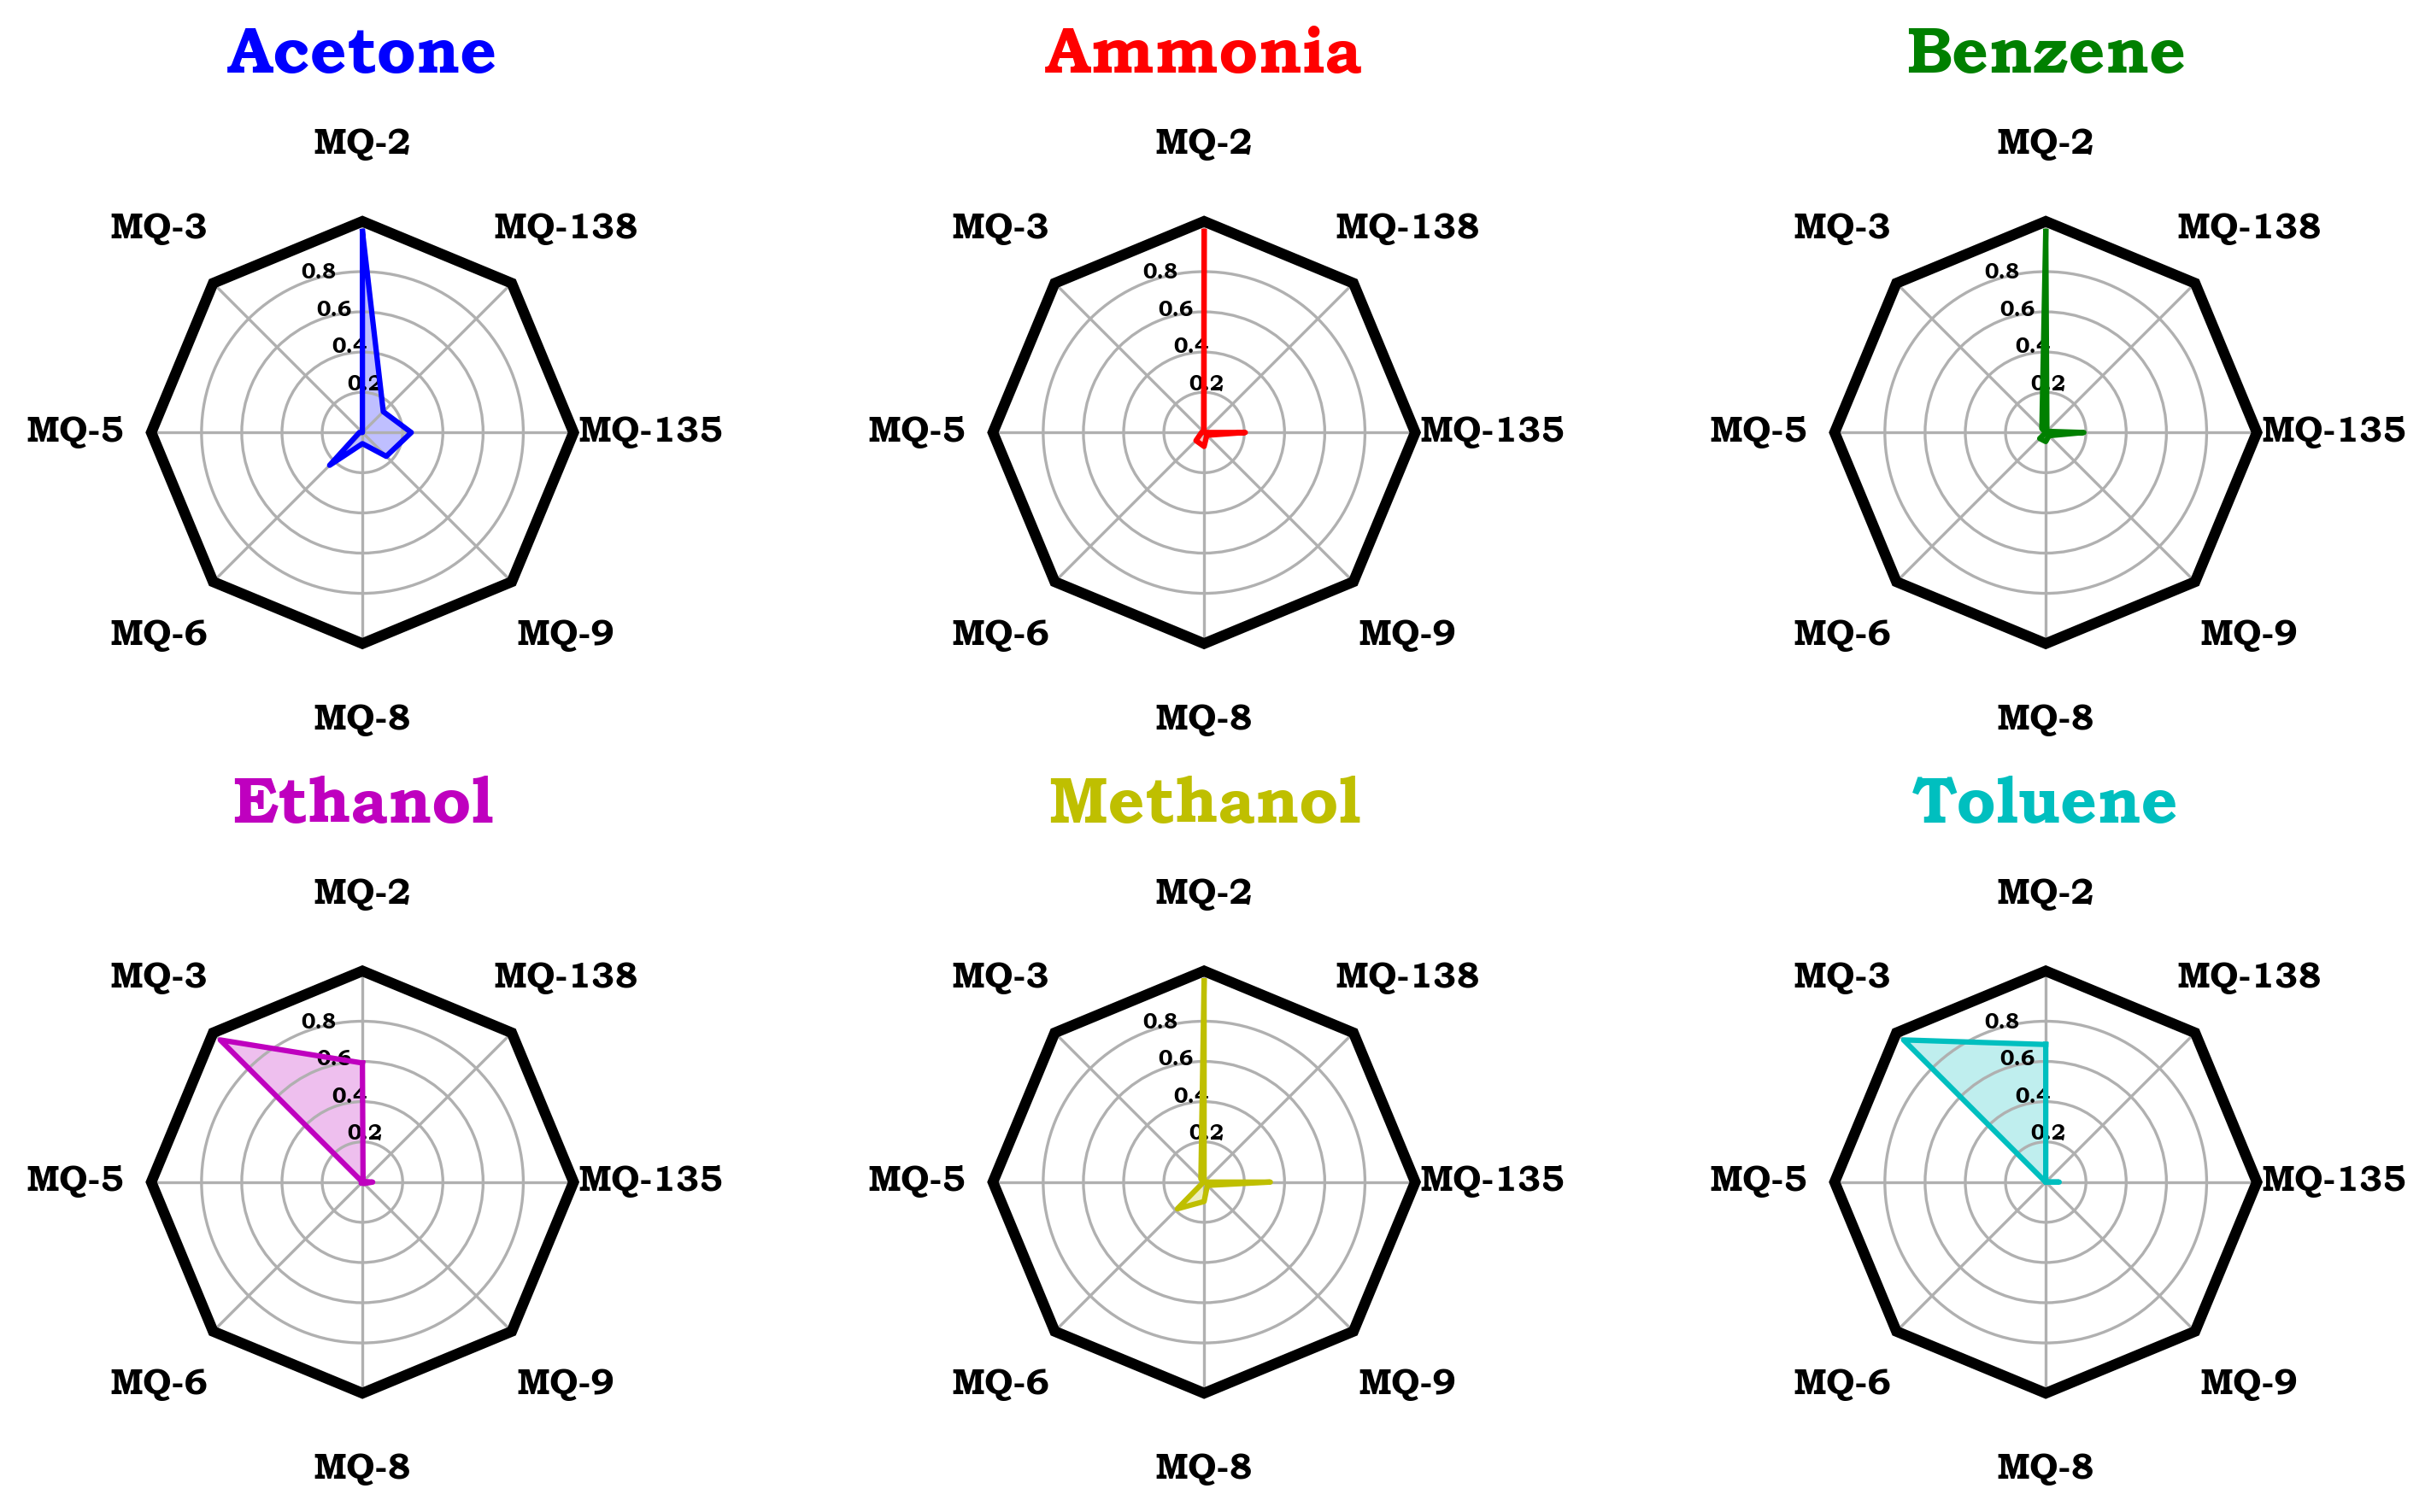

In [10]:
radar_plot(X_MOS, y, feature="PK")